In [ ]:
import pandas as pd
import os

# Read the Excel file with multiple sheets (summary 1-10)
filename = r"C:\Users\OEM\Downloads\report-generator\summary 1-10.xls"

if os.path.exists(filename):
    # Read all sheets from the Excel file
    excel_file = pd.ExcelFile(filename)
    
    print(f"Available sheets: {excel_file.sheet_names}\n")
    
    # Read all sheets into a dictionary
    dataframes = {}
    for sheet_name in excel_file.sheet_names:
        # Read the sheet - looking for header row around row 9 based on screenshot
        df = pd.read_excel(excel_file, sheet_name=sheet_name, header=9)
        
        # Remove completely empty columns
        df = df.dropna(axis=1, how='all')
        
        # Keep unnamed columns that contain data (e.g., item numbers) and drop only empty ones
        unnamed_cols = [col for col in df.columns if isinstance(col, str) and col.startswith('Unnamed')]
        cols_to_drop = [col for col in unnamed_cols if df[col].isna().all()]
        if cols_to_drop:
            df = df.drop(columns=cols_to_drop)
        
        # Rename the item number column so downstream logic can find it reliably
        if 'Unnamed: 0' in df.columns and 'Item Number' not in df.columns:
            df = df.rename(columns={'Unnamed: 0': 'Item Number'})
        
        dataframes[sheet_name] = df
        print(f"Loaded sheet '{sheet_name}': {len(df)} rows, {len(df.columns)} columns")
        print(f"  Columns: {list(df.columns)[:10]}")  # Show first 10 columns
    
    print(f"\nTotal sheets loaded: {len(dataframes)}")
else:
    print(f"File not found: {filename}")
    dataframes = {}

# Access individual sheets like: dataframes['Sheet1'], dataframes['summary 1'], etc."}

Available sheets: ['Sheet1']

Loaded sheet 'Sheet1': 2690 rows, 10 columns
  Columns: ['Year', 'Period', 'Quantity', 'Sales Amount', 'Count', 'Sales Returns', 'Count.1', 'Cost of Sales', 'Margin', 'Percent']

Total sheets loaded: 1


In [16]:
dataframes

{'Sheet1':                                     Year  Period      Quantity  Sales Amount  \
 0     Amoy All Purpose Marinade 12/450ml     NaN           NaN           NaN   
 1                                   2025     1.0           180        646.20   
 2                                   2025    10.0             6         24.30   
 3                                   2025     2.0           126        495.00   
 4                                   2025     3.0           174        626.40   
 ...                                  ...     ...           ...           ...   
 2685                                 NaN     NaN           NaN           NaN   
 2686                                 NaN     NaN           NaN           NaN   
 2687                                 NaN     NaN  Total Sales:    6981153.38   
 2688                                 NaN     NaN           NaN           NaN   
 2689                                 NaN     NaN           NaN           NaN   
 
       Count  Sa

In [ ]:
# Split data by item numbers while preserving column names
def split_by_items(df):
    """
    Split dataframe by item numbers (e.g., AMO0002, YUH0019, etc.)
    Returns a dictionary with item numbers as keys and their data as values
    Preserves original column names (including the item number column)
    """
    items_dict = {}
    current_item = None
    current_data = []
    column_names = df.columns  # Preserve original column names
    
    def finalize_item(current_rows, item_key):
        if not current_rows:
            return None
        item_df = pd.DataFrame(current_rows, columns=column_names)
        item_df = item_df.dropna(axis=1, how='all')
        if 'Item Number' in item_df.columns:
            item_df['Item Number'] = item_df['Item Number'].ffill().bfill().fillna(item_key)
        else:
            item_df.insert(0, 'Item Number', item_key)
        return item_df
    
    for idx, row in df.iterrows():
        # Check if this row contains an item number
        # Item numbers typically appear in the first column
        first_col_value = str(row.iloc[0]) if pd.notna(row.iloc[0]) else ''
        first_col_clean = first_col_value.strip()
        
        # Check if this looks like an item code (has letters AND numbers, not just "Item Total:")
        is_item_code = (first_col_clean and 
                       any(c.isalpha() for c in first_col_clean) and 
                       any(c.isdigit() for c in first_col_clean) and
                       'Item Total' not in first_col_value)
        
        if is_item_code:
            # Save previous item if exists
            if current_item and current_data:
                item_df = finalize_item(current_data, current_item)
                if item_df is not None:
                    items_dict[current_item] = item_df
            
            # Start new item
            current_item = first_col_clean
            current_data = [row.values]
        elif current_item:
            # Add row to current item
            current_data.append(row.values)
            
            # Check if this is the "Item Total:" row (end of current item)
            if 'Item Total:' in str(row.values):
                item_df = finalize_item(current_data, current_item)
                if item_df is not None:
                    items_dict[current_item] = item_df
                current_item = None
                current_data = []
    
    # Add last item if exists
    if current_item and current_data:
        item_df = finalize_item(current_data, current_item)
        if item_df is not None:
            items_dict[current_item] = item_df
    
    return items_dict

# Process each sheet
all_items = {}

for sheet_name, df in dataframes.items():
    print(f"\n--- Processing sheet: {sheet_name} ---")
    items = split_by_items(df)
    
    for item_num, item_df in items.items():
        print(f"  Item {item_num}: {len(item_df)} rows, {len(item_df.columns)} columns")
        # Store with sheet name prefix to avoid conflicts
        key = f"{sheet_name}_{item_num}"
        all_items[key] = item_df

print(f"\n\nTotal items extracted: {len(all_items)}")
print(f"Item keys: {list(all_items.keys())}")


--- Processing sheet: Sheet1 ---
  Item Amoy All Purpose Marinade 12/450ml: 13 rows, 10 columns
  Item Amoy Fish Shaomai 24pk*10pc/120g: 13 rows, 10 columns
  Item Amoy Gold Label Dark Soy 12/500ml: 13 rows, 10 columns
  Item Amoy Glutinous Rice Dumpling 24pk*3pc/180g: 12 rows, 10 columns
  Item Amoy Hoi Sin Sauce 6/2.27kg: 13 rows, 10 columns
  Item Amoy Hoi Sin Sauce 12jr*2ty/240g: 12 rows, 10 columns
  Item Amoy Japanese Teriyaki Sauce 12/450ml: 13 rows, 10 columns
  Item Amoy Mapo Tofu Sauce 12jr*2ty/220g: 12 rows, 10 columns
  Item Amoy Oyster Sauce 6/2.3kg: 8 rows, 10 columns
  Item Amoy Premium Chicken Marinade 12/450ml: 12 rows, 10 columns
  Item Amoy Shrimp Dumpling (Hargow) 24pk*6pc/102g: 13 rows, 10 columns
  Item Amoy First Extract Seafood Soy 12/500ml: 12 rows, 10 columns
  Item Amoy Pure Sesame Oil 24/150ml: 13 rows, 10 columns
  Item Amoy Rice Vinegar 12/500ml: 13 rows, 10 columns
  Item Amoy Spicy Eggplant Sauce 12jr*2ty/220g: 12 rows, 10 columns
  Item Amoy Shrimp Sha

In [4]:
# Let's debug: check the first column values to see all potential item numbers
for sheet_name, df in dataframes.items():
    print(f"\n=== Sheet: {sheet_name} ===")
    print(f"Total rows: {len(df)}")
    print(f"\nFirst column unique values (first 30):")
    
    first_col = df.iloc[:, 0]
    unique_values = first_col.dropna().unique()
    
    for i, val in enumerate(unique_values[:30]):
        print(f"  {i+1}. '{val}'")
    
    print(f"\nTotal unique values in first column: {len(unique_values)}")
    
    # Check how many look like item codes (contain letters and numbers)
    potential_items = [v for v in unique_values if pd.notna(v) and str(v).strip() and any(c.isalpha() for c in str(v)) and any(c.isdigit() for c in str(v))]
    print(f"Potential item codes found: {len(potential_items)}")
    print(f"Examples: {potential_items[:10]}")


=== Sheet: Sheet1 ===
Total rows: 2690

First column unique values (first 30):
  1. 'Amoy All Purpose Marinade 12/450ml'
  2. '2025'
  3. 'Amoy Fish Shaomai 24pk*10pc/120g'
  4. 'Amoy Gold Label Dark Soy 12/500ml'
  5. 'Amoy Glutinous Rice Dumpling 24pk*3pc/180g'
  6. 'Amoy Hoi Sin Sauce 6/2.27kg'
  7. 'Amoy Hoi Sin Sauce 12jr*2ty/240g'
  8. 'Amoy Japanese Teriyaki Sauce 12/450ml'
  9. 'Amoy Mapo Tofu Sauce 12jr*2ty/220g'
  10. 'Amoy Oyster Sauce 6/2.3kg'
  11. 'Amoy Premium Chicken Marinade 12/450ml'
  12. 'Amoy Shrimp Dumpling (Hargow) 24pk*6pc/102g'
  13. 'Amoy First Extract Seafood Soy 12/500ml'
  14. 'Amoy Pure Sesame Oil 24/150ml'
  15. 'Amoy Rice Vinegar 12/500ml'
  16. 'Amoy Spicy Eggplant Sauce 12jr*2ty/220g'
  17. 'Amoy Shrimp Shaomai 24pk*10pc/120g'
  18. 'Amoy XHot Abalone XO Sauce 12/80g'
  19. 'Amoy Zheng Jiang Spare Rib Marinade 12/450ml'
  20. 'Amoy Char Siu Sauce 12bt*2ty/275g'
  21. 'Amoy Light Soy Sauce 6/500ml'
  22. 'Amoy Oyster Sauce 6/555g'
  23. 'Amoy Marinade 

In [5]:
# Method 1: Get the first item using list() to convert keys
first_key = list(all_items.keys())[0]
first_item = all_items[first_key]

print(f"First item key: {first_key}")
print(f"\nFirst item dataframe:")
print(first_item)

# Method 2: Alternative way using next() and iter()
# first_key = next(iter(all_items))
# first_item = all_items[first_key]

First item key: Sheet1_Amoy All Purpose Marinade 12/450ml

First item dataframe:
                                  Year  Period     Quantity  Sales Amount  \
0   Amoy All Purpose Marinade 12/450ml     NaN          NaN           NaN   
1                                 2025     1.0          180        646.20   
2                                 2025    10.0            6         24.30   
3                                 2025     2.0          126        495.00   
4                                 2025     3.0          174        626.40   
5                                 2025     4.0          228        910.80   
6                                 2025     5.0          342       1385.10   
7                                 2025     6.0          198        791.93   
8                                 2025     7.0          168        734.40   
9                                 2025     8.0          300       1220.40   
10                                2025     9.0          270       1083.6

## Calculate Sales Metrics

Calculate MTD and YTD metrics based on the items data:
- **MTD Gross Sales**: Month-to-Date Sales Amount
- **MTD GP%**: Month-to-Date Gross Profit Percentage
- **YTD Gross Sales**: Year-to-Date Sales Amount
- **YTD GP%**: Year-to-Date Gross Profit Percentage

In [6]:
import datetime

def calculate_sales_metrics(all_items, target_month=10, target_year=2025):
    """
    Calculate MTD and YTD sales metrics from items data
    
    Parameters:
    - all_items: Dictionary of item dataframes
    - target_month: Month to calculate MTD for (e.g., 10 for October)
    - target_year: Year to calculate forl    
    Note: MTD Gross Sales = sum of sales for target_month
          YTD Gross Sales = sum of sales for all months from 1 to target_month
    """
    
    # Initialize accumulators
    mtd_sales = 0
    mtd_cost = 0
    ytd_sales = 0
    ytd_cost = 0
    
    # Debug counters
    items_processed = 0
    items_with_data = 0
    
    # Process each item
    for item_key, item_df in all_items.items():
        items_processed += 1
        
        # Skip if dataframe is empty
        if item_df.empty:
            continue
        
        # Make a copy to work with
        df = item_df.copy()
        
        # Find the correct column names (handling potential variations)
        year_col = None
        period_col = None
        sales_col = None
        cost_col = None
        
        for col in df.columns:
            col_lower = str(col).strip().lower()
            if 'year' in col_lower and not year_col:
                year_col = col
            elif 'period' in col_lower and not period_col:
                period_col = col
            elif 'sales amount' in col_lower and not sales_col:
                sales_col = col
            elif 'cost of sales' in col_lower and not cost_col:
                cost_col = col
        
        # Skip if we don't have the required columns
        if not year_col or not period_col or not sales_col:
            continue
        
        # Convert to numeric
        df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
        df[period_col] = pd.to_numeric(df[period_col], errors='coerce')
        df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce').fillna(0)
        if cost_col:
            df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce').fillna(0)
        
        # Filter for target year
        year_data = df[df[year_col] == target_year].copy()
        
        if not year_data.empty:
            items_with_data += 1
            
            # Calculate MTD (for specific month only)
            mtd_data = year_data[year_data[period_col] == target_month]
            mtd_sales += mtd_data[sales_col].sum()
            if cost_col:
                mtd_cost += mtd_data[cost_col].sum()
            
            # Calculate YTD (sum of ALL months from 1 to target_month)
            ytd_data = year_data[year_data[period_col] <= target_month]
            ytd_sales += ytd_data[sales_col].sum()
            if cost_col:
                ytd_cost += ytd_data[cost_col].sum()
    
    # Calculate GP% (Gross Profit Percentage)
    mtd_gp = ((mtd_sales - mtd_cost) / mtd_sales * 100) if mtd_sales > 0 else 0
    ytd_gp = ((ytd_sales - ytd_cost) / ytd_sales * 100) if ytd_sales > 0 else 0
    
    print(f"Debug: Processed {items_processed} items, {items_with_data} had data for year {target_year}")
    
    return {
        'MTD Gross Sales': mtd_sales,
        'MTD GP%': mtd_gp,
        'YTD Gross Sales': ytd_sales,
        'YTD GP%': ytd_gp,
        'MTD Cost': mtd_cost,
        'YTD Cost': ytd_cost
    }

# Calculate for October 2025
results_2025 = calculate_sales_metrics(all_items, target_month=10, target_year=2025)

print("\n=== 2025 Results (October) ===")
print(f"MTD Gross Sales: ${results_2025['MTD Gross Sales']:,.2f}")
print(f"MTD GP%: {results_2025['MTD GP%']:.2f}%")
print(f"YTD Gross Sales: ${results_2025['YTD Gross Sales']:,.2f}")
print(f"YTD GP%: {results_2025['YTD GP%']:.2f}%")

# Calculate for 2024 for comparison
results_2024 = calculate_sales_metrics(all_items, target_month=10, target_year=2024)

print("\n=== 2024 Results (October) ===")
print(f"MTD Gross Sales: ${results_2024['MTD Gross Sales']:,.2f}")
print(f"MTD GP%: {results_2024['MTD GP%']:.2f}%")
print(f"YTD Gross Sales: ${results_2024['YTD Gross Sales']:,.2f}")
print(f"YTD GP%: {results_2024['YTD GP%']:.2f}%")

# Calculate % Achieved (2025 vs 2024)
print("\n=== % Achieved (2025 vs 2024) ===")
mtd_achieved = (results_2025['MTD Gross Sales'] / results_2024['MTD Gross Sales'] * 100) if results_2024['MTD Gross Sales'] > 0 else 0
ytd_achieved = (results_2025['YTD Gross Sales'] / results_2024['YTD Gross Sales'] * 100) if results_2024['YTD Gross Sales'] > 0 else 0
print(f"MTD Achieved: {mtd_achieved:.0f}%")
print(f"YTD Achieved: {ytd_achieved:.0f}%")

Debug: Processed 255 items, 255 had data for year 2025

=== 2025 Results (October) ===
MTD Gross Sales: $210,669.77
MTD GP%: 26.23%
YTD Gross Sales: $6,941,250.96
YTD GP%: 21.90%
Debug: Processed 255 items, 0 had data for year 2024

=== 2024 Results (October) ===
MTD Gross Sales: $0.00
MTD GP%: 0.00%
YTD Gross Sales: $0.00
YTD GP%: 0.00%

=== % Achieved (2025 vs 2024) ===
MTD Achieved: 0%
YTD Achieved: 0%
Debug: Processed 255 items, 0 had data for year 2024

=== 2024 Results (October) ===
MTD Gross Sales: $0.00
MTD GP%: 0.00%
YTD Gross Sales: $0.00
YTD GP%: 0.00%

=== % Achieved (2025 vs 2024) ===
MTD Achieved: 0%
YTD Achieved: 0%


In [8]:
# Create a summary report matching the image format
# Calculate %Achieved for GP% - show 0% if no 2024 data to compare against
mtd_gp_achieved = "0%" if results_2024['MTD GP%'] == 0 else f"{(results_2025['MTD GP%'] / results_2024['MTD GP%'] * 100):.0f}%"
ytd_gp_achieved = "0%" if results_2024['YTD GP%'] == 0 else f"{(results_2025['YTD GP%'] / results_2024['YTD GP%'] * 100):.0f}%"

# Budget data - to be loaded from another sheet
budget_mtd_sales = None  # To be loaded
budget_mtd_gp = None     # To be loaded
budget_ytd_sales = None  # To be loaded
budget_ytd_gp = None     # To be loaded

# Calculate % Achieved vs Budget (2025 actual / 2025 budget * 100)
mtd_budget_achieved = "0%" if budget_mtd_sales is None else f"{(results_2025['MTD Gross Sales'] / budget_mtd_sales * 100):.0f}%"
mtd_gp_budget_achieved = "0%" if budget_mtd_gp is None else f"{(results_2025['MTD GP%'] / budget_mtd_gp * 100):.0f}%"
ytd_budget_achieved = "0%" if budget_ytd_sales is None else f"{(results_2025['YTD Gross Sales'] / budget_ytd_sales * 100):.0f}%"
ytd_gp_budget_achieved = "0%" if budget_ytd_gp is None else f"{(results_2025['YTD GP%'] / budget_ytd_gp * 100):.0f}%"

summary_data = {
    'Date': ['2025', '2024', '%Achieved', '2025 Budget', '% Achieved'],
    'MTD Gross Sales': [
        f"$ {results_2025['MTD Gross Sales']:,.2f}",
        f"$ {results_2024['MTD Gross Sales']:,.2f}",
        f"{mtd_achieved:.0f}%",  # 2025 MTD / 2024 MTD * 100
        "" if budget_mtd_sales is None else f"$ {budget_mtd_sales:,.2f}",
        mtd_budget_achieved  # 2025 MTD / Budget MTD * 100
    ],
    'MTD GP%': [
        f"{results_2025['MTD GP%']:.2f}%",
        f"{results_2024['MTD GP%']:.2f}%",
        mtd_gp_achieved,  # 2025 GP% / 2024 GP% * 100
        "" if budget_mtd_gp is None else f"{budget_mtd_gp:.2f}%",
        mtd_gp_budget_achieved  # 2025 GP% / Budget GP% * 100
    ],
    'YTD Gross Sales': [
        f"$ {results_2025['YTD Gross Sales']:,.2f}",
        f"$ {results_2024['YTD Gross Sales']:,.2f}",
        f"{ytd_achieved:.0f}%",  # 2025 YTD / 2024 YTD * 100
        "" if budget_ytd_sales is None else f"$ {budget_ytd_sales:,.2f}",
        ytd_budget_achieved  # 2025 YTD / Budget YTD * 100
    ],
    'YTD GP%': [
        f"{results_2025['YTD GP%']:.2f}%",
        f"{results_2024['YTD GP%']:.2f}%",
        ytd_gp_achieved,  # 2025 GP% / 2024 GP% * 100
        "" if budget_ytd_gp is None else f"{budget_ytd_gp:.2f}%",
        ytd_gp_budget_achieved  # 2025 GP% / Budget GP% * 100
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== Sales Summary Report ===")
print(summary_df.to_string(index=False))


=== Sales Summary Report ===
       Date MTD Gross Sales MTD GP% YTD Gross Sales YTD GP%
       2025    $ 210,669.77  26.23%  $ 6,941,250.96  21.90%
       2024          $ 0.00   0.00%          $ 0.00   0.00%
  %Achieved              0%      0%              0%      0%
2025 Budget                                                
 % Achieved              0%      0%              0%      0%


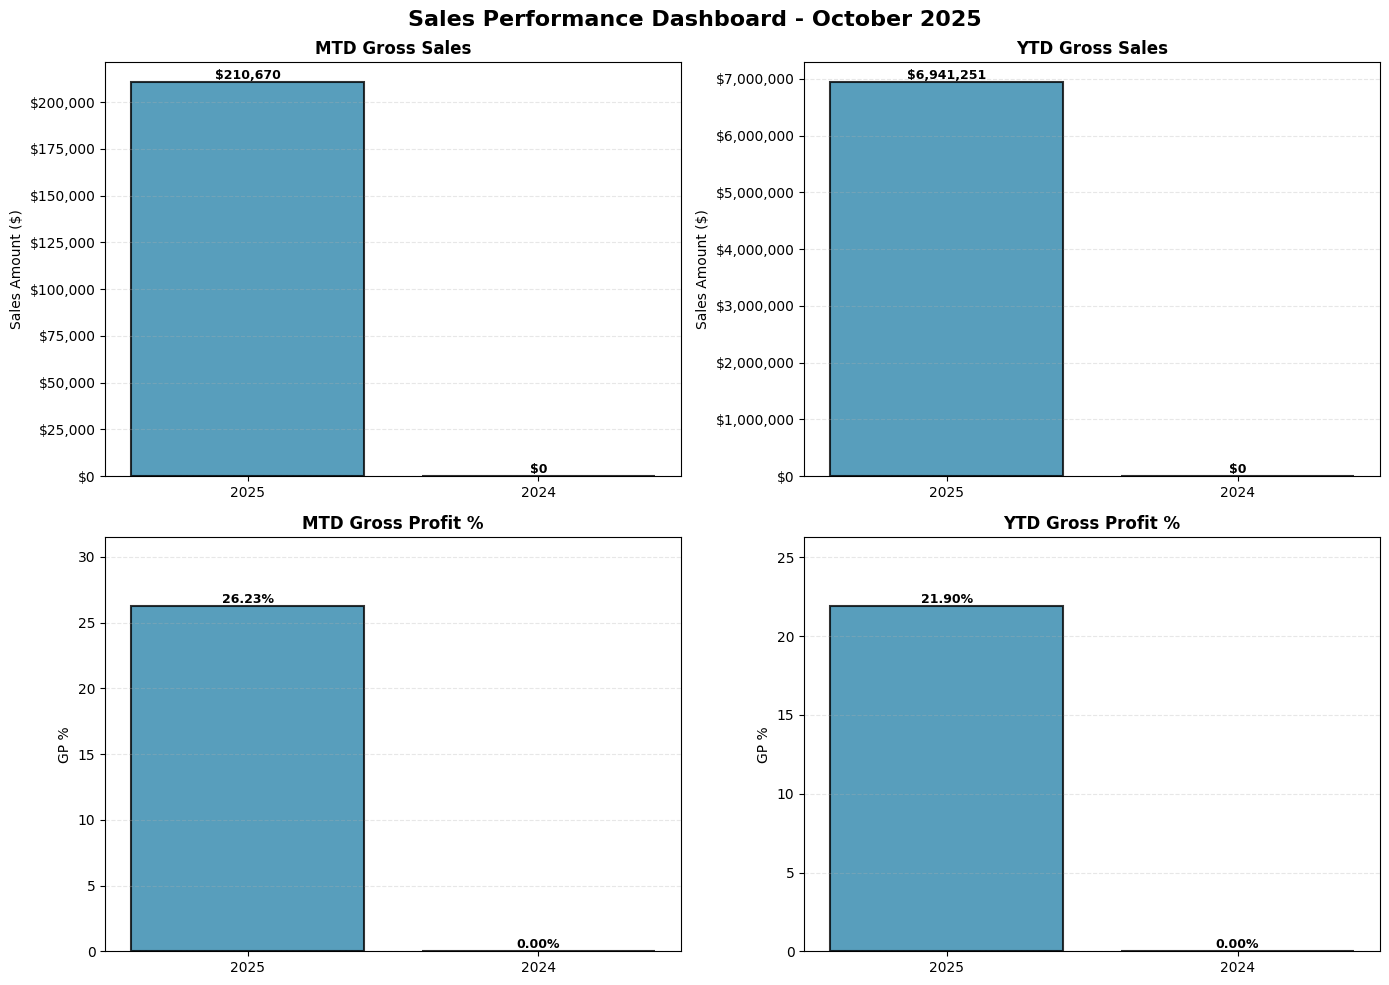

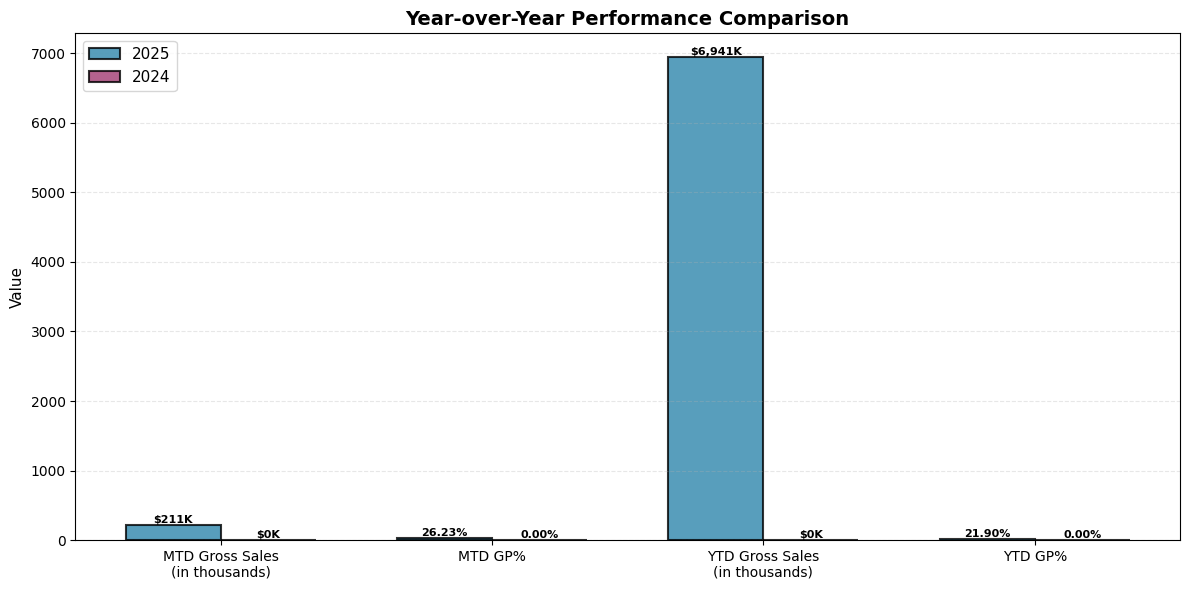


✓ Charts generated successfully!


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a professional visualization of the sales summary
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sales Performance Dashboard - October 2025', fontsize=16, fontweight='bold')

# Data for plotting
categories = ['2025', '2024']
mtd_sales_values = [results_2025['MTD Gross Sales'], results_2024['MTD Gross Sales']]
ytd_sales_values = [results_2025['YTD Gross Sales'], results_2024['YTD Gross Sales']]
mtd_gp_values = [results_2025['MTD GP%'], results_2024['MTD GP%']]
ytd_gp_values = [results_2025['YTD GP%'], results_2024['YTD GP%']]

# Color scheme
colors_2025_2024 = ['#2E86AB', '#A23B72']  # Blue for 2025, Pink for 2024

# 1. MTD Gross Sales Bar Chart
ax1 = axes[0, 0]
bars1 = ax1.bar(categories, mtd_sales_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_title('MTD Gross Sales', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sales Amount ($)', fontsize=10)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
# Add % achieved annotation
if results_2024['MTD Gross Sales'] > 0:
    ax1.text(0.5, max(mtd_sales_values) * 0.95, 
            f'% Achieved: {mtd_achieved:.0f}%',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# 2. YTD Gross Sales Bar Chart
ax2 = axes[0, 1]
bars2 = ax2.bar(categories, ytd_sales_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_title('YTD Gross Sales', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sales Amount ($)', fontsize=10)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
# Add % achieved annotation
if results_2024['YTD Gross Sales'] > 0:
    ax2.text(0.5, max(ytd_sales_values) * 0.95,
            f'% Achieved: {ytd_achieved:.0f}%',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. MTD GP% Bar Chart
ax3 = axes[1, 0]
bars3 = ax3.bar(categories, mtd_gp_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_title('MTD Gross Profit %', fontsize=12, fontweight='bold')
ax3.set_ylabel('GP %', fontsize=10)
ax3.set_ylim(0, max(mtd_gp_values) * 1.2)
# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
# Add % achieved annotation if applicable
if results_2024['MTD GP%'] > 0:
    gp_achieved = (results_2025['MTD GP%'] / results_2024['MTD GP%'] * 100)
    ax3.text(0.5, max(mtd_gp_values) * 0.95,
            f'% Achieved: {gp_achieved:.0f}%',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# 4. YTD GP% Bar Chart
ax4 = axes[1, 1]
bars4 = ax4.bar(categories, ytd_gp_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_title('YTD Gross Profit %', fontsize=12, fontweight='bold')
ax4.set_ylabel('GP %', fontsize=10)
ax4.set_ylim(0, max(ytd_gp_values) * 1.2)
# Add value labels on bars
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
# Add % achieved annotation if applicable
if results_2024['YTD GP%'] > 0:
    gp_achieved = (results_2025['YTD GP%'] / results_2024['YTD GP%'] * 100)
    ax4.text(0.5, max(ytd_gp_values) * 0.95,
            f'% Achieved: {gp_achieved:.0f}%',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax4.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Create a second chart showing year-over-year comparison
fig2, ax = plt.subplots(1, 1, figsize=(12, 6))

# Prepare data for grouped bar chart
x = np.arange(4)  # 4 metrics
width = 0.35  # width of bars

metrics = ['MTD Gross Sales\n(in thousands)', 'MTD GP%', 'YTD Gross Sales\n(in thousands)', 'YTD GP%']
values_2025 = [
    results_2025['MTD Gross Sales'] / 1000,  # Convert to thousands
    results_2025['MTD GP%'],
    results_2025['YTD Gross Sales'] / 1000,  # Convert to thousands
    results_2025['YTD GP%']
]
values_2024 = [
    results_2024['MTD Gross Sales'] / 1000,  # Convert to thousands
    results_2024['MTD GP%'],
    results_2024['YTD Gross Sales'] / 1000,  # Convert to thousands
    results_2024['YTD GP%']
]

bars1 = ax.bar(x - width/2, values_2025, width, label='2025', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, values_2024, width, label='2024', color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Year-over-Year Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Value', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Format based on metric type (sales vs GP%)
        if i in [0, 2]:  # Sales metrics
            label = f'${height:,.0f}K'
        else:  # GP% metrics
            label = f'{height:.2f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Charts generated successfully!")

In [12]:
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.drawing.image import Image as XLImage
import io

# Create a new workbook
wb = Workbook()
ws = wb.active
ws.title = "Sales Summary Report"

# Write the title
ws['A1'] = "Sales Summary Report - October 2025"
ws['A1'].font = Font(size=14, bold=True)
ws['A1'].alignment = Alignment(horizontal='center')
ws.merge_cells('A1:E1')

# Define styling
header_fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
header_font = Font(color="FFFFFF", bold=True)
row_2025_fill = PatternFill(start_color="E7E6E6", end_color="E7E6E6", fill_type="solid")
row_achieved_fill = PatternFill(start_color="FFF2CC", end_color="FFF2CC", fill_type="solid")
row_budget_fill = PatternFill(start_color="D9E1F2", end_color="D9E1F2", fill_type="solid")

border_style = Border(
    left=Side(style='thin'),
    right=Side(style='thin'),
    top=Side(style='thin'),
    bottom=Side(style='thin')
)

# Write headers (row 3)
headers = ['Date', 'MTD Gross Sales', 'MTD GP%', 'YTD Gross Sales', 'YTD GP%']
for col_num, header in enumerate(headers, 1):
    cell = ws.cell(row=3, column=col_num, value=header)
    cell.font = header_font
    cell.fill = header_fill
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.border = border_style

# Prepare data rows
data_rows = [
    ['2025', 
     results_2025['MTD Gross Sales'], 
     results_2025['MTD GP%'] / 100,  # Convert to decimal for percentage format
     results_2025['YTD Gross Sales'], 
     results_2025['YTD GP%'] / 100],
    ['2024', 
     results_2024['MTD Gross Sales'], 
     results_2024['MTD GP%'] / 100, 
     results_2024['YTD Gross Sales'], 
     results_2024['YTD GP%'] / 100],
    ['%Achieved', 
     mtd_achieved / 100 if results_2024['MTD Gross Sales'] > 0 else 0,
     float(mtd_gp_achieved.rstrip('%')) / 100 if mtd_gp_achieved != "0%" else 0,
     ytd_achieved / 100 if results_2024['YTD Gross Sales'] > 0 else 0,
     float(ytd_gp_achieved.rstrip('%')) / 100 if ytd_gp_achieved != "0%" else 0],
    ['2025 Budget', '', '', '', ''],
    ['% Achieved', 0, 0, 0, 0]  # Budget comparison - currently 0%
]

# Write data rows with formatting
for row_idx, row_data in enumerate(data_rows, start=4):
    for col_idx, value in enumerate(row_data, start=1):
        cell = ws.cell(row=row_idx, column=col_idx, value=value)
        cell.border = border_style
        cell.alignment = Alignment(horizontal='right' if col_idx > 1 else 'left', vertical='center')
        
        # Apply row-specific fills
        if row_data[0] == '2025':
            cell.fill = row_2025_fill
        elif '%Achieved' in row_data[0]:
            cell.fill = row_achieved_fill
        elif 'Budget' in row_data[0]:
            cell.fill = row_budget_fill
        
        # Format numbers
        if col_idx > 1 and value != '':
            if col_idx in [2, 4]:  # Sales columns
                cell.number_format = '$#,##0.00'
            elif col_idx in [3, 5]:  # GP% columns
                cell.number_format = '0.00%'

# Set column widths
ws.column_dimensions['A'].width = 15
ws.column_dimensions['B'].width = 18
ws.column_dimensions['C'].width = 12
ws.column_dimensions['D'].width = 18
ws.column_dimensions['E'].width = 12

# Add row heights
ws.row_dimensions[1].height = 25
ws.row_dimensions[3].height = 20

# Save charts as images and add to Excel
# Chart 1: Dashboard
fig_dashboard, axes = plt.subplots(2, 2, figsize=(12, 9))
fig_dashboard.suptitle('Sales Performance Dashboard - October 2025', fontsize=14, fontweight='bold')

categories = ['2025', '2024']
mtd_sales_values = [results_2025['MTD Gross Sales'], results_2024['MTD Gross Sales']]
ytd_sales_values = [results_2025['YTD Gross Sales'], results_2024['YTD Gross Sales']]
mtd_gp_values = [results_2025['MTD GP%'], results_2024['MTD GP%']]
ytd_gp_values = [results_2025['YTD GP%'], results_2024['YTD GP%']]
colors_2025_2024 = ['#2E86AB', '#A23B72']

# MTD Gross Sales
ax1 = axes[0, 0]
bars1 = ax1.bar(categories, mtd_sales_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_title('MTD Gross Sales', fontsize=11, fontweight='bold')
ax1.set_ylabel('Sales Amount ($)', fontsize=9)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'${height:,.0f}',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
if results_2024['MTD Gross Sales'] > 0:
    ax1.text(0.5, max(mtd_sales_values) * 0.92, f'% Achieved: {mtd_achieved:.0f}%',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# YTD Gross Sales
ax2 = axes[0, 1]
bars2 = ax2.bar(categories, ytd_sales_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_title('YTD Gross Sales', fontsize=11, fontweight='bold')
ax2.set_ylabel('Sales Amount ($)', fontsize=9)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'${height:,.0f}',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
if results_2024['YTD Gross Sales'] > 0:
    ax2.text(0.5, max(ytd_sales_values) * 0.92, f'% Achieved: {ytd_achieved:.0f}%',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# MTD GP%
ax3 = axes[1, 0]
bars3 = ax3.bar(categories, mtd_gp_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_title('MTD Gross Profit %', fontsize=11, fontweight='bold')
ax3.set_ylabel('GP %', fontsize=9)
ax3.set_ylim(0, max(mtd_gp_values) * 1.2)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
if results_2024['MTD GP%'] > 0:
    gp_achieved = (results_2025['MTD GP%'] / results_2024['MTD GP%'] * 100)
    ax3.text(0.5, max(mtd_gp_values) * 0.92, f'% Achieved: {gp_achieved:.0f}%',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# YTD GP%
ax4 = axes[1, 1]
bars4 = ax4.bar(categories, ytd_gp_values, color=colors_2025_2024, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_title('YTD Gross Profit %', fontsize=11, fontweight='bold')
ax4.set_ylabel('GP %', fontsize=9)
ax4.set_ylim(0, max(ytd_gp_values) * 1.2)
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
if results_2024['YTD GP%'] > 0:
    gp_achieved = (results_2025['YTD GP%'] / results_2024['YTD GP%'] * 100)
    ax4.text(0.5, max(ytd_gp_values) * 0.92, f'% Achieved: {gp_achieved:.0f}%',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax4.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save dashboard chart to bytes
img_buffer1 = io.BytesIO()
fig_dashboard.savefig(img_buffer1, format='png', dpi=150, bbox_inches='tight')
img_buffer1.seek(0)
plt.close(fig_dashboard)

# Create a new sheet for the dashboard chart
ws_chart1 = wb.create_sheet("Dashboard Chart")
img1 = XLImage(img_buffer1)
ws_chart1.add_image(img1, 'A1')

# Chart 2: Comparison chart
fig_comparison, ax = plt.subplots(1, 1, figsize=(11, 6))
x = np.arange(4)
width = 0.35
metrics = ['MTD Gross Sales\n(in thousands)', 'MTD GP%', 'YTD Gross Sales\n(in thousands)', 'YTD GP%']
values_2025 = [
    results_2025['MTD Gross Sales'] / 1000,
    results_2025['MTD GP%'],
    results_2025['YTD Gross Sales'] / 1000,
    results_2025['YTD GP%']
]
values_2024 = [
    results_2024['MTD Gross Sales'] / 1000,
    results_2024['MTD GP%'],
    results_2024['YTD Gross Sales'] / 1000,
    results_2024['YTD GP%']
]

bars1 = ax.bar(x - width/2, values_2025, width, label='2025', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, values_2024, width, label='2024', color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Year-over-Year Performance Comparison', fontsize=13, fontweight='bold')
ax.set_ylabel('Value', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=9)
ax.legend(fontsize=10, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i in [0, 2]:
            label = f'${height:,.0f}K'
        else:
            label = f'{height:.2f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()

# Save comparison chart to bytes
img_buffer2 = io.BytesIO()
fig_comparison.savefig(img_buffer2, format='png', dpi=150, bbox_inches='tight')
img_buffer2.seek(0)
plt.close(fig_comparison)

# Create a new sheet for the comparison chart
ws_chart2 = wb.create_sheet("Comparison Chart")
img2 = XLImage(img_buffer2)
ws_chart2.add_image(img2, 'A1')

# Save the workbook
output_filename = r"C:\Users\OEM\Downloads\report-generator\Sales_Summary_Report.xlsx"
wb.save(output_filename)

print(f"\n✓ Excel file created successfully: {output_filename}")
print(f"  - Sheet 1: Sales Summary Report (formatted table)")
print(f"  - Sheet 2: Dashboard Chart (4-panel visualization)")
print(f"  - Sheet 3: Comparison Chart (year-over-year comparison)")
print(f"\nThe Excel file includes:")
print(f"  • Formatted summary table matching the screenshot layout")
print(f"  • Professional styling with colors and borders")
print(f"  • Currency and percentage formatting")
print(f"  • Two chart visualizations as images")


✓ Excel file created successfully: C:\Users\OEM\Downloads\report-generator\Sales_Summary_Report.xlsx
  - Sheet 1: Sales Summary Report (formatted table)
  - Sheet 2: Dashboard Chart (4-panel visualization)
  - Sheet 3: Comparison Chart (year-over-year comparison)

The Excel file includes:
  • Formatted summary table matching the screenshot layout
  • Professional styling with colors and borders
  • Currency and percentage formatting
  • Two chart visualizations as images


In [ ]:
# Aggregate items into brands, compute Top-10 MTD by Brand and export to Excel
import re
from collections import defaultdict
import pandas as pd
import io
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side

# Parameters
target_month = 10
target_year = 2025
prev_year = target_year - 1

# Helper: extract letter prefix from item code (e.g., AMO0002 -> AMO)
def extract_brand_code(item_key):
    # item_key format from earlier: "<sheet>_<itemcode>"; get the last part
    code = str(item_key).split('_')[-1]
    m = re.match(r'([A-Za-z]+)', code)
    return m.group(1).upper() if m else code.upper()

# Helper: compute metrics for a single item dataframe and a given year
def compute_item_year_metrics(item_df, year, month):
    # Find col names similar to earlier logic
    df = item_df.copy()
    year_col = None
    period_col = None
    sales_col = None
    cost_col = None
    desc_col = None
    for col in df.columns:
        col_lower = str(col).strip().lower()
        if 'year' in col_lower and not year_col:
            year_col = col
        elif 'period' in col_lower and not period_col:
            period_col = col
        elif 'sales amount' in col_lower and not sales_col:
            sales_col = col
        elif 'cost of sales' in col_lower and not cost_col:
            cost_col = col
        elif any(k in col_lower for k in ['description','item','name']) and not desc_col:
            desc_col = col

    # If essential cols missing, return zeros
    if not year_col or not period_col or not sales_col:
        return {'mtd_sales':0.0,'mtd_cost':0.0,'ytd_sales':0.0,'ytd_cost':0.0,'desc':None}

    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    df[period_col] = pd.to_numeric(df[period_col], errors='coerce')
    df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce').fillna(0)
    if cost_col:
        df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce').fillna(0)

    year_data = df[df[year_col] == year]
    if year_data.empty:
        return {'mtd_sales':0.0,'mtd_cost':0.0,'ytd_sales':0.0,'ytd_cost':0.0,'desc':None}

    mtd_data = year_data[year_data[period_col] == month]
    ytd_data = year_data[year_data[period_col] <= month]

    mtd_sales = float(mtd_data[sales_col].sum())
    mtd_cost = float(mtd_data[cost_col].sum()) if cost_col else 0.0
    ytd_sales = float(ytd_data[sales_col].sum())
    ytd_cost = float(ytd_data[cost_col].sum()) if cost_col else 0.0

    # get a description sample (first non-null in desc_col)
    desc_val = None
    if desc_col is not None:
        non_nulls = df[desc_col].dropna().astype(str)
        if len(non_nulls):
            desc_val = non_nulls.iloc[0]

    return {'mtd_sales':mtd_sales,'mtd_cost':mtd_cost,'ytd_sales':ytd_sales,'ytd_cost':ytd_cost,'desc':desc_val}

# Group items by brand code
brands = defaultdict(list)
item_desc_samples = defaultdict(list)

for item_key, item_df in all_items.items():
    brand_code = extract_brand_code(item_key)
    brands[brand_code].append((item_key, item_df))

# Aggregate per brand for both years
brand_metrics = []
for brand_code, items in brands.items():
    agg = {
        'brand_code': brand_code,
        'brand_name': None,
        '2025_mtd_sales': 0.0,
        '2025_mtd_cost': 0.0,
        '2025_ytd_sales': 0.0,
        '2025_ytd_cost': 0.0,
        '2024_mtd_sales': 0.0,
        '2024_mtd_cost': 0.0,
        '2024_ytd_sales': 0.0,
        '2024_ytd_cost': 0.0,
    }
    desc_sets = []
    for item_key, item_df in items:
        # compute for 2025
        metrics_2025 = compute_item_year_metrics(item_df, target_year, target_month)
        metrics_2024 = compute_item_year_metrics(item_df, prev_year, target_month)
        agg['2025_mtd_sales'] += metrics_2025['mtd_sales']
        agg['2025_mtd_cost'] += metrics_2025['mtd_cost']
        agg['2025_ytd_sales'] += metrics_2025['ytd_sales']
        agg['2025_ytd_cost'] += metrics_2025['ytd_cost']
        agg['2024_mtd_sales'] += metrics_2024['mtd_sales']
        agg['2024_mtd_cost'] += metrics_2024['mtd_cost']
        agg['2024_ytd_sales'] += metrics_2024['ytd_sales']
        agg['2024_ytd_cost'] += metrics_2024['ytd_cost']

        # collect desc first 3 words set
        desc = metrics_2025.get('desc') or metrics_2024.get('desc')
        if desc:
            words = [w.strip().upper() for w in re.split(r'\s+', str(desc)) if w.strip()]
            first3 = words[:3]
            if first3:
                desc_sets.append(set(first3))

    # Determine brand_name: intersection of all desc_sets first3 words
    if desc_sets:
        common = set.intersection(*desc_sets) if len(desc_sets) > 1 else desc_sets[0]
        if common:
            # preserve order by looking at first item's desc
            sample_desc = None
            for _, df in items:
                # attempt to find description column again
                for col in df.columns:
                    if any(k in str(col).lower() for k in ['description','item','name']):
                        non_nulls = df[col].dropna().astype(str)
                        if len(non_nulls):
                            sample_desc = non_nulls.iloc[0]
                            break
                if sample_desc:
                    break
            if sample_desc:
                sample_words = [w.strip() for w in re.split(r'\s+', sample_desc) if w.strip()]
                brand_words = [w for w in sample_words[:3] if w.upper() in common]
                brand_name = ' '.join(brand_words)
            else:
                brand_name = ' '.join(list(common))
        else:
            brand_name = brand_code
    else:
        brand_name = brand_code

    agg['brand_name'] = brand_name

    # compute GP% for each year
    def compute_gp(sales, cost):
        return ((sales - cost) / sales * 100) if sales > 0 else 0.0

    agg['2025_mtd_gp'] = compute_gp(agg['2025_mtd_sales'], agg['2025_mtd_cost'])
    agg['2025_ytd_gp'] = compute_gp(agg['2025_ytd_sales'], agg['2025_ytd_cost'])
    agg['2024_mtd_gp'] = compute_gp(agg['2024_mtd_sales'], agg['2024_mtd_cost'])
    agg['2024_ytd_gp'] = compute_gp(agg['2024_ytd_sales'], agg['2024_ytd_cost'])

    # % Achieved vs 2024 for MTD
    agg['mtd_achieved_pct'] = (agg['2025_mtd_sales'] / agg['2024_mtd_sales'] * 100) if agg['2024_mtd_sales'] > 0 else 0.0

    brand_metrics.append(agg)

# Convert to DataFrame and pick top 10 by 2025 MTD sales
bm_df = pd.DataFrame(brand_metrics)
if bm_df.empty:
    print('\nNo brand metrics could be computed (missing columns or data).')
else:
    bm_df = bm_df.sort_values(by='2025_mtd_sales', ascending=False).head(10)

    # Format columns similar to screenshot
    output_rows = []
    for i, row in bm_df.reset_index(drop=True).iterrows():
        output_rows.append({
            'Rank': i+1,
            'Brand': row['brand_name'],
            '2025 MTD Gross Sales': row['2025_mtd_sales'],
            '2025 MTD GP%': row['2025_mtd_gp'],
            '2024 MTD Gross Sales': row['2024_mtd_sales'],
            '2024 MTD GP%': row['2024_mtd_gp'],
            '2025 MTD Budget ($)': None,
            '% Achieved vs 2024': row['mtd_achieved_pct'],
            '% Achieved vs Budget': None
        })

    out_df = pd.DataFrame(output_rows)

    # Save to Excel with formatting (openpyxl)
    out_path = r"C:\Users\OEM\Downloads\report-generator\Top10_Brand_MTD_Report.xlsx"
    wb = Workbook()
    ws = wb.active
    ws.title = 'Top 10 MTD Brands'

    # Header row
    headers = list(out_df.columns)
    for c_idx, h in enumerate(headers, start=1):
        cell = ws.cell(row=2, column=c_idx, value=h)
        cell.font = Font(bold=True, color='FFFFFF')
        cell.fill = PatternFill(start_color='4F81BD', end_color='4F81BD', fill_type='solid')
        cell.alignment = Alignment(horizontal='center')
        cell.border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))

    # Write data rows
    for r_idx, row in enumerate(out_df.itertuples(index=False), start=3):
        for c_idx, value in enumerate(row, start=1):
            cell = ws.cell(row=r_idx, column=c_idx, value=value)
            cell.border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))
            if headers[c_idx-1] in ['2025 MTD Gross Sales','2024 MTD Gross Sales','2025 MTD Budget ($)'] and value is not None:
                cell.number_format = '$#,##0.00'
                cell.alignment = Alignment(horizontal='right')
            elif headers[c_idx-1] in ['2025 MTD GP%','2024 MTD GP%','% Achieved vs 2024','% Achieved vs Budget'] and value is not None:
                cell.number_format = '0.00%'
                cell.alignment = Alignment(horizontal='right')
            else:
                cell.alignment = Alignment(horizontal='left' if c_idx==2 else 'right')

    # Adjust column widths
    widths = [6, 22, 18, 12, 18, 12, 18, 14, 16]
    for i, w in enumerate(widths, start=1):
        ws.column_dimensions[ws.cell(row=2, column=i).column_letter].width = w

    # Title in A1
    ws.merge_cells('A1:I1')
    tcell = ws['A1']
    tcell.value = f'Top 10 MTD Brand Performance - {target_month}/{target_year}'
    tcell.font = Font(size=14, bold=True)
    tcell.alignment = Alignment(horizontal='center')

    wb.save(out_path)
    print(f"\n✓ Top-10 brand report created: {out_path}")

# End of brand aggregation & export cell

In [ ]:
# Generate Top-10 Brand Reports for both MTD and YTD
import re
from collections import defaultdict
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side

# Parameters
target_month = 10
target_year = 2025
prev_year = target_year - 1

# Helper: extract letter prefix from item code (e.g., AMO0002 -> AMO)
def extract_brand_code(item_key):
    code = str(item_key).split('_')[-1]
    m = re.match(r'([A-Za-z]+)', code)
    return m.group(1).upper() if m else code.upper()

# Helper: compute metrics for a single item dataframe and a given year
def compute_item_year_metrics(item_df, year, month):
    df = item_df.copy()
    year_col = None
    period_col = None
    sales_col = None
    cost_col = None
    desc_col = None
    
    for col in df.columns:
        col_lower = str(col).strip().lower()
        if 'year' in col_lower and not year_col:
            year_col = col
        elif 'period' in col_lower and not period_col:
            period_col = col
        elif 'sales amount' in col_lower and not sales_col:
            sales_col = col
        elif 'cost of sales' in col_lower and not cost_col:
            cost_col = col
        elif any(k in col_lower for k in ['description','item','name']) and not desc_col:
            desc_col = col

    if not year_col or not period_col or not sales_col:
        return {'mtd_sales':0.0,'mtd_cost':0.0,'ytd_sales':0.0,'ytd_cost':0.0,'desc':None}

    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    df[period_col] = pd.to_numeric(df[period_col], errors='coerce')
    df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce').fillna(0)
    if cost_col:
        df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce').fillna(0)

    year_data = df[df[year_col] == year]
    if year_data.empty:
        return {'mtd_sales':0.0,'mtd_cost':0.0,'ytd_sales':0.0,'ytd_cost':0.0,'desc':None}

    mtd_data = year_data[year_data[period_col] == month]
    ytd_data = year_data[year_data[period_col] <= month]

    mtd_sales = float(mtd_data[sales_col].sum())
    mtd_cost = float(mtd_data[cost_col].sum()) if cost_col else 0.0
    ytd_sales = float(ytd_data[sales_col].sum())
    ytd_cost = float(ytd_data[cost_col].sum()) if cost_col else 0.0

    desc_val = None
    if desc_col is not None:
        non_nulls = df[desc_col].dropna().astype(str)
        if len(non_nulls):
            desc_val = non_nulls.iloc[0]

    return {'mtd_sales':mtd_sales,'mtd_cost':mtd_cost,'ytd_sales':ytd_sales,'ytd_cost':ytd_cost,'desc':desc_val}

# Group items by brand code (exclude MX brand)
brands = defaultdict(list)
for item_key, item_df in all_items.items():
    brand_code = extract_brand_code(item_key)
    # Skip MX brand
    if brand_code == 'MX':
        continue
    brands[brand_code].append((item_key, item_df))

# Aggregate per brand for both MTD and YTD
brand_metrics = []
for brand_code, items in brands.items():
    agg = {
        'brand_code': brand_code,
        'brand_name': None,
        '2025_mtd_sales': 0.0,
        '2025_mtd_cost': 0.0,
        '2025_ytd_sales': 0.0,
        '2025_ytd_cost': 0.0,
        '2024_mtd_sales': 0.0,
        '2024_mtd_cost': 0.0,
        '2024_ytd_sales': 0.0,
        '2024_ytd_cost': 0.0,
    }
    desc_sets = []
    
    for item_key, item_df in items:
        metrics_2025 = compute_item_year_metrics(item_df, target_year, target_month)
        metrics_2024 = compute_item_year_metrics(item_df, prev_year, target_month)
        
        agg['2025_mtd_sales'] += metrics_2025['mtd_sales']
        agg['2025_mtd_cost'] += metrics_2025['mtd_cost']
        agg['2025_ytd_sales'] += metrics_2025['ytd_sales']
        agg['2025_ytd_cost'] += metrics_2025['ytd_cost']
        agg['2024_mtd_sales'] += metrics_2024['mtd_sales']
        agg['2024_mtd_cost'] += metrics_2024['mtd_cost']
        agg['2024_ytd_sales'] += metrics_2024['ytd_sales']
        agg['2024_ytd_cost'] += metrics_2024['ytd_cost']
        
        desc = metrics_2025.get('desc') or metrics_2024.get('desc')
        if desc:
            words = [w.strip().upper() for w in re.split(r'\s+', str(desc)) if w.strip()]
            first3 = words[:3]
            if first3:
                desc_sets.append(set(first3))
    
    # Determine brand name from common words
    if desc_sets:
        common = set.intersection(*desc_sets) if len(desc_sets) > 1 else desc_sets[0]
        if common:
            sample_desc = None
            for _, df in items:
                for col in df.columns:
                    if any(k in str(col).lower() for k in ['description','item','name']):
                        non_nulls = df[col].dropna().astype(str)
                        if len(non_nulls):
                            sample_desc = non_nulls.iloc[0]
                            break
                if sample_desc:
                    break
            if sample_desc:
                sample_words = [w.strip() for w in re.split(r'\s+', sample_desc) if w.strip()]
                brand_words = [w for w in sample_words[:3] if w.upper() in common]
                brand_name = ' '.join(brand_words)
            else:
                brand_name = ' '.join(list(common))
        else:
            brand_name = brand_code
    else:
        brand_name = brand_code
    
    agg['brand_name'] = brand_name
    
    # Compute GP%
    def compute_gp(sales, cost):
        return ((sales - cost) / sales * 100) if sales > 0 else 0.0
    
    agg['2025_mtd_gp'] = compute_gp(agg['2025_mtd_sales'], agg['2025_mtd_cost'])
    agg['2025_ytd_gp'] = compute_gp(agg['2025_ytd_sales'], agg['2025_ytd_cost'])
    agg['2024_mtd_gp'] = compute_gp(agg['2024_mtd_sales'], agg['2024_mtd_cost'])
    agg['2024_ytd_gp'] = compute_gp(agg['2024_ytd_sales'], agg['2024_ytd_cost'])
    
    # % Achieved
    agg['mtd_achieved_pct'] = (agg['2025_mtd_sales'] / agg['2024_mtd_sales'] * 100) if agg['2024_mtd_sales'] > 0 else 0.0
    agg['ytd_achieved_pct'] = (agg['2025_ytd_sales'] / agg['2024_ytd_sales'] * 100) if agg['2024_ytd_sales'] > 0 else 0.0
    
    brand_metrics.append(agg)

# Convert to DataFrame
bm_df = pd.DataFrame(brand_metrics)

if bm_df.empty:
    print('\nNo brand metrics could be computed (missing columns or data).')
else:
    # Create Top 10 MTD Report
    print(f"\n{'='*80}")
    print("TOP 10 BRANDS BY MTD GROSS SALES")
    print(f"{'='*80}\n")
    
    top10_mtd = bm_df.sort_values(by='2025_mtd_sales', ascending=False).head(10)
    
    mtd_output = []
    for i, row in top10_mtd.reset_index(drop=True).iterrows():
        mtd_output.append({
            'Rank': i+1,
            'Brand': row['brand_name'],
            '2025 MTD Sales': f"${row['2025_mtd_sales']:,.2f}",
            '2025 MTD GP%': f"{row['2025_mtd_gp']:.2f}%",
            '2024 MTD Sales': f"${row['2024_mtd_sales']:,.2f}",
            '2024 MTD GP%': f"{row['2024_mtd_gp']:.2f}%",
            '% Achieved': f"{row['mtd_achieved_pct']:.2f}%"
        })
    
    mtd_preview = pd.DataFrame(mtd_output)
    print(mtd_preview.to_string(index=False))
    
    # Create Top 10 YTD Report
    print(f"\n\n{'='*80}")
    print("TOP 10 BRANDS BY YTD GROSS SALES")
    print(f"{'='*80}\n")
    
    top10_ytd = bm_df.sort_values(by='2025_ytd_sales', ascending=False).head(10)
    
    ytd_output = []
    for i, row in top10_ytd.reset_index(drop=True).iterrows():
        ytd_output.append({
            'Rank': i+1,
            'Brand': row['brand_name'],
            '2025 YTD Sales': f"${row['2025_ytd_sales']:,.2f}",
            '2025 YTD GP%': f"{row['2025_ytd_gp']:.2f}%",
            '2024 YTD Sales': f"${row['2024_ytd_sales']:,.2f}",
            '2024 YTD GP%': f"{row['2024_ytd_gp']:.2f}%",
            '% Achieved': f"{row['ytd_achieved_pct']:.2f}%"
        })
    
    ytd_preview = pd.DataFrame(ytd_output)
    print(ytd_preview.to_string(index=False))
    
    # Save both reports to Excel files with charts
    def create_brand_excel(df_sorted, metric_type, file_suffix):
        import matplotlib.pyplot as plt
        import numpy as np
        import io
        from openpyxl.drawing.image import Image as XLImage
        
        wb = Workbook()
        ws = wb.active
        ws.title = f'Top 10 {metric_type} Brands'
        
        # Title
        ws.merge_cells('A1:I1')
        tcell = ws['A1']
        tcell.value = f'Top 10 {metric_type} Brand Performance - {target_month}/{target_year}'
        tcell.font = Font(size=14, bold=True)
        tcell.alignment = Alignment(horizontal='center')
        
        # Header styling
        header_fill = PatternFill(start_color="FFEB9C", end_color="FFEB9C", fill_type="solid")
        green_fill = PatternFill(start_color="C6E0B4", end_color="C6E0B4", fill_type="solid")
        blue_fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
        
        headers = ['', 'Brand', 
                   f'{target_year} {metric_type}\nGross Sales', f'{target_year} {metric_type}\nGP%',
                   f'{prev_year} {metric_type}\nGross Sales', f'{prev_year} {metric_type}\nGP%',
                   f'{target_year} {metric_type}\nBudget ($)', 
                   f'% Achieved vs\n{prev_year}', '% Achieved vs\nBudget']
        
        for c_idx, h in enumerate(headers, start=1):
            cell = ws.cell(row=2, column=c_idx, value=h)
            cell.font = Font(bold=True, size=10)
            cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
            cell.border = Border(left=Side(style='thin'), right=Side(style='thin'),
                               top=Side(style='thin'), bottom=Side(style='thin'))
            
            if c_idx in [3, 4]:
                cell.fill = header_fill
            elif c_idx in [5, 6]:
                cell.fill = green_fill
            elif c_idx in [7, 8, 9]:
                cell.fill = blue_fill
        
        # Write data
        sales_key = f'{target_year}_{metric_type.lower()}_sales'
        gp_key = f'{target_year}_{metric_type.lower()}_gp'
        prev_sales_key = f'{prev_year}_{metric_type.lower()}_sales'
        prev_gp_key = f'{prev_year}_{metric_type.lower()}_gp'
        achieved_key = f'{metric_type.lower()}_achieved_pct'
        
        for r_idx, row in df_sorted.reset_index(drop=True).iterrows():
            rank = r_idx + 1
            row_data = [
                rank, 
                row['brand_name'],
                row[sales_key],
                row[gp_key] / 100,
                row[prev_sales_key],
                row[prev_gp_key] / 100,
                None,
                row[achieved_key] / 100,
                None
            ]
            
            excel_row = r_idx + 3
            for c_idx, value in enumerate(row_data, start=1):
                cell = ws.cell(row=excel_row, column=c_idx, value=value)
                cell.border = Border(left=Side(style='thin'), right=Side(style='thin'),
                                   top=Side(style='thin'), bottom=Side(style='thin'))
                
                if c_idx in [3, 5, 7]:
                    cell.number_format = '$#,##0.00'
                    cell.alignment = Alignment(horizontal='right')
                elif c_idx in [4, 6, 8, 9]:
                    cell.number_format = '0.00%'
                    cell.alignment = Alignment(horizontal='right')
                elif c_idx == 1:
                    cell.alignment = Alignment(horizontal='center')
                else:
                    cell.alignment = Alignment(horizontal='left')
        
        # Column widths
        widths = [6, 22, 18, 12, 18, 12, 18, 14, 16]
        for i, w in enumerate(widths, start=1):
            ws.column_dimensions[ws.cell(row=2, column=i).column_letter].width = w
        
        ws.row_dimensions[1].height = 25
        ws.row_dimensions[2].height = 35
        
        # Create charts
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'Top 10 Brands - {metric_type} Performance ({target_month}/{target_year})', 
                     fontsize=14, fontweight='bold')
        
        # Extract data for charts
        brands = df_sorted['brand_name'].head(10).tolist()
        sales_2025 = df_sorted[sales_key].head(10).tolist()
        sales_2024 = df_sorted[prev_sales_key].head(10).tolist()
        gp_2025 = df_sorted[gp_key].head(10).tolist()
        gp_2024 = df_sorted[prev_gp_key].head(10).tolist()
        
        # Chart 1: Sales Comparison
        x = np.arange(len(brands))
        width = 0.35
        
        bars1 = ax1.barh(x - width/2, sales_2025, width, label=str(target_year), 
                        color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
        bars2 = ax1.barh(x + width/2, sales_2024, width, label=str(prev_year), 
                        color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1)
        
        ax1.set_xlabel('Sales Amount ($)', fontsize=10, fontweight='bold')
        ax1.set_ylabel('Brand', fontsize=10, fontweight='bold')
        ax1.set_title(f'{metric_type} Gross Sales', fontsize=11, fontweight='bold')
        ax1.set_yticks(x)
        ax1.set_yticklabels(brands, fontsize=8)
        ax1.legend(fontsize=9)
        ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.invert_yaxis()
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                width_val = bar.get_width()
                ax1.text(width_val, bar.get_y() + bar.get_height()/2.,
                        f'${width_val/1000:.0f}K',
                        ha='left', va='center', fontsize=7, fontweight='bold')
        
        # Chart 2: GP% Comparison
        bars3 = ax2.barh(x - width/2, gp_2025, width, label=str(target_year), 
                        color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
        bars4 = ax2.barh(x + width/2, gp_2024, width, label=str(prev_year), 
                        color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1)
        
        ax2.set_xlabel('GP %', fontsize=10, fontweight='bold')
        ax2.set_title(f'{metric_type} Gross Profit %', fontsize=11, fontweight='bold')
        ax2.set_yticks(x)
        ax2.set_yticklabels(brands, fontsize=8)
        ax2.legend(fontsize=9)
        ax2.grid(axis='x', alpha=0.3, linestyle='--')
        ax2.invert_yaxis()
        
        # Add value labels
        for bars in [bars3, bars4]:
            for bar in bars:
                width_val = bar.get_width()
                ax2.text(width_val, bar.get_y() + bar.get_height()/2.,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=7, fontweight='bold')
        
        plt.tight_layout()
        
        # Save chart to bytes
        img_buffer = io.BytesIO()
        fig.savefig(img_buffer, format='png', dpi=150, bbox_inches='tight')
        img_buffer.seek(0)
        plt.close(fig)
        
        # Add chart to new sheet
        ws_chart = wb.create_sheet(f"{metric_type} Charts")
        img = XLImage(img_buffer)
        ws_chart.add_image(img, 'A1')
        
        # Save
        out_path = rf"C:\Users\OEM\Downloads\report-generator\Top10_Brand_{metric_type}_Report.xlsx"
        wb.save(out_path)
        return out_path
    
    # Generate both Excel files
    mtd_path = create_brand_excel(top10_mtd, 'MTD', 'mtd')
    ytd_path = create_brand_excel(top10_ytd, 'YTD', 'ytd')
    
    print(f"\n\n✓ Excel files created successfully:")
    print(f"  • MTD Report: {mtd_path}")
    print(f"  • YTD Report: {ytd_path}")
    print(f"\nTotal brands identified: {len(brands)}")

In [ ]:
# Generate Top-20 SKU Reports for both MTD and YTD
import re
from collections import defaultdict
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
import matplotlib.pyplot as plt
import numpy as np
import io
from openpyxl.drawing.image import Image as XLImage

# Parameters
target_month = 10
target_year = 2025
prev_year = target_year - 1

# Helper functions already defined above
# extract_brand_code, compute_item_year_metrics

def get_sku_code_and_name(item_df):
    """Extract original item code and a readable name from the dataframe."""
    if item_df.empty:
        return '', ''

    first_row = item_df.iloc[0]

    # Prefer explicit item number columns
    code = ''
    for col in item_df.columns:
        col_lower = str(col).lower()
        if 'item' in col_lower and any(k in col_lower for k in ['no', 'number', '#', 'code']):
            val = first_row[col]
            if pd.notna(val):
                val_str = str(val).strip()
                if val_str:
                    code = val_str.split()[0]
                    break

    # Fallback: parse first cell for letters+digits pattern
    if not code:
        raw_value = str(first_row.iloc[0]).strip()
        match = re.search(r'([A-Za-z]+\d+)', raw_value)
        if match:
            code = match.group(1)
        elif raw_value:
            code = raw_value.split()[0]

    # Find description column
    name = ''
    for col in item_df.columns:
        col_lower = str(col).lower()
        if any(key in col_lower for key in ['description', 'item name', 'item desc', 'name']):
            val = first_row[col]
            if pd.notna(val):
                val_str = str(val).strip()
                if val_str and (not code or not val_str.upper().startswith(code.upper())):
                    name = val_str
                    break

    # Fallback: remove code prefix from first cell text
    if not name:
        raw_value = str(first_row.iloc[0]).strip()
        if code and raw_value.upper().startswith(code.upper()):
            remainder = raw_value[len(code):].strip(' -:_')
            if remainder:
                name = remainder
        elif raw_value and raw_value != code:
            name = raw_value

    if not code:
        code = name or ''
    if not name:
        name = code

    return code.strip(), name.strip()

# Collect all SKUs with their metrics (exclude MX products)
sku_metrics = []

for item_key, item_df in all_items.items():
    if item_df.empty:
        continue

    sku_code, item_name = get_sku_code_and_name(item_df)
    if not sku_code:
        continue

    brand_code = extract_brand_code(sku_code)
    if brand_code == 'MX':
        continue

    # Compute metrics for both years
    metrics_current = compute_item_year_metrics(item_df, target_year, target_month)
    metrics_previous = compute_item_year_metrics(item_df, prev_year, target_month)

    # Calculate GP%
    def compute_gp(sales, cost):
        return ((sales - cost) / sales * 100) if sales > 0 else 0.0

    current_mtd_gp = compute_gp(metrics_current['mtd_sales'], metrics_current['mtd_cost'])
    current_ytd_gp = compute_gp(metrics_current['ytd_sales'], metrics_current['ytd_cost'])
    previous_mtd_gp = compute_gp(metrics_previous['mtd_sales'], metrics_previous['mtd_cost'])
    previous_ytd_gp = compute_gp(metrics_previous['ytd_sales'], metrics_previous['ytd_cost'])

    # Store metrics
    sku_metrics.append({
        'code': sku_code,
        'name': item_name,
        f'{target_year}_mtd_sales': metrics_current['mtd_sales'],
        f'{target_year}_mtd_qty': 0,  # Quantity not available in current data structure
        f'{target_year}_mtd_gp': current_mtd_gp,
        f'{prev_year}_mtd_sales': metrics_previous['mtd_sales'],
        f'{prev_year}_mtd_qty': 0,
        f'{prev_year}_mtd_gp': previous_mtd_gp,
        f'{target_year}_ytd_sales': metrics_current['ytd_sales'],
        f'{target_year}_ytd_qty': 0,
        f'{target_year}_ytd_gp': current_ytd_gp,
        f'{prev_year}_ytd_sales': metrics_previous['ytd_sales'],
        f'{prev_year}_ytd_qty': 0,
        f'{prev_year}_ytd_gp': previous_ytd_gp,
    })

# Convert to DataFrame
sku_df = pd.DataFrame(sku_metrics)

if sku_df.empty:
    print('\nNo SKU metrics could be computed (missing columns or data).')
else:
    # Function to create SKU Excel report
    def create_sku_excel(df_sorted, metric_type):
        wb = Workbook()
        ws = wb.active
        ws.title = f'Top 20 {metric_type} SKUs'
        
        # Title
        ws.merge_cells('A1:I1')
        tcell = ws['A1']
        tcell.value = f'Top 20 {metric_type} SKUs Performance'
        tcell.font = Font(size=14, bold=True)
        tcell.alignment = Alignment(horizontal='center')
        
        # Header row styling
        header_fill_yellow = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
        header_fill_green = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")
        
        metric_lower = metric_type.lower()
        
        headers = [
            ('', None),
            ('Code', None),
            ('Item Name', None),
            (f'{target_year} {metric_type}\nGross Sales', header_fill_yellow),
            (f'{target_year} {metric_type}\nQTY', header_fill_yellow),
            (f'{target_year} {metric_type}\nGP%', header_fill_yellow),
            (f'{prev_year} {metric_type}\nGross Sales', header_fill_green),
            (f'{prev_year} {metric_type}\nQTY', header_fill_green),
            (f'{prev_year} {metric_type} GP%', header_fill_green)
        ]
        
        for c_idx, (h, fill) in enumerate(headers, start=1):
            cell = ws.cell(row=2, column=c_idx, value=h)
            cell.font = Font(bold=True, size=10)
            cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
            cell.border = Border(left=Side(style='thin'), right=Side(style='thin'),
                               top=Side(style='thin'), bottom=Side(style='thin'))
            if fill:
                cell.fill = fill
        
        # Write data rows
        for r_idx, row in df_sorted.reset_index(drop=True).iterrows():
            rank = r_idx + 1
            row_data = [
                rank,
                row['code'],
                row['name'],
                row[f'{target_year}_{metric_lower}_sales'],
                row[f'{target_year}_{metric_lower}_qty'],
                row[f'{target_year}_{metric_lower}_gp'] / 100,
                row[f'{prev_year}_{metric_lower}_sales'],
                row[f'{prev_year}_{metric_lower}_qty'],
                row[f'{prev_year}_{metric_lower}_gp'] / 100
            ]
            
            excel_row = r_idx + 3
            
            for c_idx, value in enumerate(row_data, start=1):
                cell = ws.cell(row=excel_row, column=c_idx, value=value)
                cell.border = Border(left=Side(style='thin'), right=Side(style='thin'),
                                   top=Side(style='thin'), bottom=Side(style='thin'))
                
                # Apply formatting
                if c_idx in [4, 7]:  # Sales columns
                    cell.number_format = '#,##0.00'
                    cell.alignment = Alignment(horizontal='right')
                elif c_idx in [5, 8]:  # QTY columns
                    cell.number_format = '#,##0'
                    cell.alignment = Alignment(horizontal='right')
                elif c_idx in [6, 9]:  # GP% columns
                    cell.number_format = '0.00%'
                    cell.alignment = Alignment(horizontal='right')
                elif c_idx == 1:  # Rank
                    cell.alignment = Alignment(horizontal='center')
                elif c_idx == 2:  # Code
                    cell.alignment = Alignment(horizontal='left')
                else:  # Item name
                    cell.alignment = Alignment(horizontal='left')
        
        # Set column widths
        widths = [5, 12, 50, 15, 12, 12, 15, 12, 14]
        for i, w in enumerate(widths, start=1):
            ws.column_dimensions[ws.cell(row=2, column=i).column_letter].width = w
        
        ws.row_dimensions[1].height = 25
        ws.row_dimensions[2].height = 35
        
        # Create charts
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
        fig.suptitle(f'Top 20 SKUs - {metric_type} Performance ({target_month}/{target_year})', 
                     fontsize=14, fontweight='bold')
        
        # Extract data for charts (top 20)
        skus_list = [f"{row['code'][:10]}..." if len(row['code']) > 10 else row['code'] 
                     for _, row in df_sorted.head(20).iterrows()]
        sales_current = df_sorted[f'{target_year}_{metric_lower}_sales'].head(20).tolist()
        sales_previous = df_sorted[f'{prev_year}_{metric_lower}_sales'].head(20).tolist()
        gp_current = df_sorted[f'{target_year}_{metric_lower}_gp'].head(20).tolist()
        gp_previous = df_sorted[f'{prev_year}_{metric_lower}_gp'].head(20).tolist()
        
        # Chart 1: Sales Comparison
        y_pos = np.arange(len(skus_list))
        width = 0.35
        
        bars1 = ax1.barh(y_pos - width/2, sales_current, width, label=str(target_year), 
                        color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=0.8)
        bars2 = ax1.barh(y_pos + width/2, sales_previous, width, label=str(prev_year), 
                        color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.8)
        
        ax1.set_xlabel('Sales Amount ($)', fontsize=10, fontweight='bold')
        ax1.set_ylabel('SKU Code', fontsize=10, fontweight='bold')
        ax1.set_title(f'{metric_type} Gross Sales', fontsize=11, fontweight='bold')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(skus_list, fontsize=7)
        ax1.legend(fontsize=9)
        ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.invert_yaxis()
        
        # Chart 2: GP% Comparison
        bars3 = ax2.barh(y_pos - width/2, gp_current, width, label=str(target_year), 
                        color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=0.8)
        bars4 = ax2.barh(y_pos + width/2, gp_previous, width, label=str(prev_year), 
                        color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.8)
        
        ax2.set_xlabel('GP %', fontsize=10, fontweight='bold')
        ax2.set_title(f'{metric_type} Gross Profit %', fontsize=11, fontweight='bold')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(skus_list, fontsize=7)
        ax2.legend(fontsize=9)
        ax2.grid(axis='x', alpha=0.3, linestyle='--')
        ax2.invert_yaxis()
        
        plt.tight_layout()
        
        # Save chart to bytes
        img_buffer = io.BytesIO()
        fig.savefig(img_buffer, format='png', dpi=150, bbox_inches='tight')
        img_buffer.seek(0)
        plt.close(fig)
        
        # Add chart to new sheet
        ws_chart = wb.create_sheet(f"{metric_type} Charts")
        img = XLImage(img_buffer)
        ws_chart.add_image(img, 'A1')
        
        # Save
        out_path = rf"C:\Users\OEM\Downloads\report-generator\Top20_SKU_{metric_type}_Report.xlsx"
        wb.save(out_path)
        return out_path
    
    # Generate MTD report
    print(f"\n{'='*80}")
    print("TOP 20 SKUs BY MTD GROSS SALES")
    print(f"{'='*80}\n")
    
    top20_mtd = sku_df.sort_values(by=f'{target_year}_mtd_sales', ascending=False).head(20)
    
    mtd_preview = []
    for idx, row in top20_mtd.reset_index(drop=True).iterrows():
        mtd_preview.append({
            'Rank': idx + 1,
            'Code': row['code'],
            'Item Name': row['name'][:40] + '...' if len(row['name']) > 40 else row['name'],
            f'{target_year} MTD Sales': f"${row[f'{target_year}_mtd_sales']:,.2f}",
            f'{target_year} GP%': f"{row[f'{target_year}_mtd_gp']:.2f}%",
            f'{prev_year} MTD Sales': f"${row[f'{prev_year}_mtd_sales']:,.2f}",
            f'{prev_year} GP%': f"{row[f'{prev_year}_mtd_gp']:.2f}%"
        })
    
    mtd_preview_df = pd.DataFrame(mtd_preview)
    print(mtd_preview_df.to_string(index=False))
    
    # Generate YTD report
    print(f"\n\n{'='*80}")
    print("TOP 20 SKUs BY YTD GROSS SALES")
    print(f"{'='*80}\n")
    
    top20_ytd = sku_df.sort_values(by=f'{target_year}_ytd_sales', ascending=False).head(20)
    
    ytd_preview = []
    for idx, row in top20_ytd.reset_index(drop=True).iterrows():
        ytd_preview.append({
            'Rank': idx + 1,
            'Code': row['code'],
            'Item Name': row['name'][:40] + '...' if len(row['name']) > 40 else row['name'],
            f'{target_year} YTD Sales': f"${row[f'{target_year}_ytd_sales']:,.2f}",
            f'{target_year} GP%': f"{row[f'{target_year}_ytd_gp']:.2f}%",
            f'{prev_year} YTD Sales': f"${row[f'{prev_year}_ytd_sales']:,.2f}",
            f'{prev_year} GP%': f"{row[f'{prev_year}_ytd_gp']:.2f}%"
        })
    
    ytd_preview_df = pd.DataFrame(ytd_preview)
    print(ytd_preview_df.to_string(index=False))
    
    # Generate Excel files
    mtd_path = create_sku_excel(top20_mtd, 'MTD')
    ytd_path = create_sku_excel(top20_ytd, 'YTD')
    
    print(f"\n\n✓ Excel files created successfully:")
    print(f"  • MTD Report: {mtd_path}")
    print(f"  • YTD Report: {ytd_path}")
    print(f"\nTotal SKUs identified: {len(sku_df)}")


In [14]:
    """Create Top-20 SKU MTD or YTD Performance report (excludes MX products)"""
    
    # Collect all SKUs with their metrics
    sku_metrics = []
    
    for item_key, item_df in all_items.items():
        print(item_key, item_df)
        break


Sheet1_Amoy All Purpose Marinade 12/450ml                                   Year  Period     Quantity  Sales Amount  \
0   Amoy All Purpose Marinade 12/450ml     NaN          NaN           NaN   
1                                 2025     1.0          180        646.20   
2                                 2025    10.0            6         24.30   
3                                 2025     2.0          126        495.00   
4                                 2025     3.0          174        626.40   
5                                 2025     4.0          228        910.80   
6                                 2025     5.0          342       1385.10   
7                                 2025     6.0          198        791.93   
8                                 2025     7.0          168        734.40   
9                                 2025     8.0          300       1220.40   
10                                2025     9.0          270       1083.60   
11                                